# Current speed vs obs

In [1]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.


/home/156/aek156/.local/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
cc.start_cluster()

If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 39178:127.0.0.1:39178 vdi-n23.nci.org.au -l aek156


Client Scheduler: tcp://127.0.0.1:33677 Dashboard: http://127.0.0.1:39178/status,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


In [3]:
from joblib import Memory
memory = Memory(cachedir='/g/data1/v45/cosima-cookbook/', verbose=0)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/g/data1/v45/cosima-cookbook/'", use "location=None" instead.
  from ipykernel import kernelapp as app


In [4]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
#     plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [5]:
obs_file = xr.open_dataset('/g/data3/hh5/tmp/cosima/observations/original/drifter_annualmeans.nc').rename({'Lat':'latitude','Lon':'longitude'})
obs_u = obs_file['U']
obs_v = obs_file['V']
# obs_lat = obs_file['latitude']
# obs_lon = obs_file['longitude']
obs_speed = np.sqrt(obs_u**2+obs_v**2)
# obs_speed = np.swapaxes(obs_speed,0,1)
del(obs_u, obs_v)

In [6]:
clim_years = 20  # how many years to use for model climatology

In [7]:
# location coords: [ minlon, maxlon, minlat, maxlat ]
# key names are used as filenames so should not have spaces
locations = { 
#               'EAC_ACC_SouthPacific': [140-360,240-360,-65,-20], 
#               'EAC_ACC':             [140-360,190-360,-65,-20],
              'EAC':                     [145-360,175-360,-45,-20],
              'Kuroshio':                [125-360,155-360,25,50],
              'GulfStream':             [-85,-50,25,50],
              'Agulhas':                 [10,40,-45,-20]
    # TODO: ACC
}

In [8]:
# load model speed climatologies and snapshots
speeds = copy.deepcopy(exptdata.exptdict)  # this will store speed fields under the same keys as exptdata.exptdict
for ekey in speeds.keys():
#     if ekey=='025deg': # for testing
        expt = speeds[ekey]['expt']
        print(ekey)

        ## Load zonal velocity from expt
        tmp = cc.get_nc_variable(expt, 'ocean.nc', 'u', time_units = 'days since 1900-01-01')

        tend = tmp['time'].data[-1]  # final time in model data
        tstart = tmp['time'].data[0]  # first time in model data
        tclimend = tend  # end of climatology  --  NB: type should be numpy.datetime64 but might be <class 'datetime.datetime'>
        if isinstance(tclimend, np.datetime64):
            tclimstart = pd.to_datetime(tclimend) - pd.DateOffset(years=clim_years) + pd.DateOffset(days=1)  # start of climatology
            tclimstart = tclimstart.to_datetime64()  # match to time type
        else:
            tclimstart = tclimend - pd.DateOffset(years=clim_years) + pd.DateOffset(days=1)  # start of climatology

        u = tmp.isel(st_ocean=0).sel(time=slice(tclimstart,tclimend)).mean('time')
        u_snap = tmp.isel(st_ocean=0).isel(time=-1)


        ## Load meridional velocity from expt 
        tmp = cc.get_nc_variable(expt, 'ocean.nc', 'v', time_units = 'days since 1900-01-01')
        v = tmp.isel(st_ocean=0).sel(time=slice(tclimstart,tclimend)).mean('time')
        v_snap = tmp.isel(st_ocean=0).isel(time=-1)
        speeds[ekey]['speed'] = np.sqrt(u**2+v**2)
        speeds[ekey]['speed_snap'] = np.sqrt(u_snap**2+v_snap**2)
        speeds[ekey]['tend'] = tend
        speeds[ekey]['tstart'] = tstart
        speeds[ekey]['tclimend'] = tclimend
        speeds[ekey]['tclimstart'] = tclimstart
        del(tmp, u, v)

1deg


/home/156/aek156/github/OceansAus/cosima-cookbook/cosima_cookbook/netcdf_index.py:386: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  decoded_time = xr.conventions.times.decode_cf_datetime(dataarray.time, time_units)


025deg


/home/156/aek156/github/OceansAus/cosima-cookbook/cosima_cookbook/netcdf_index.py:386: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  decoded_time = xr.conventions.times.decode_cf_datetime(dataarray.time, time_units)


01deg


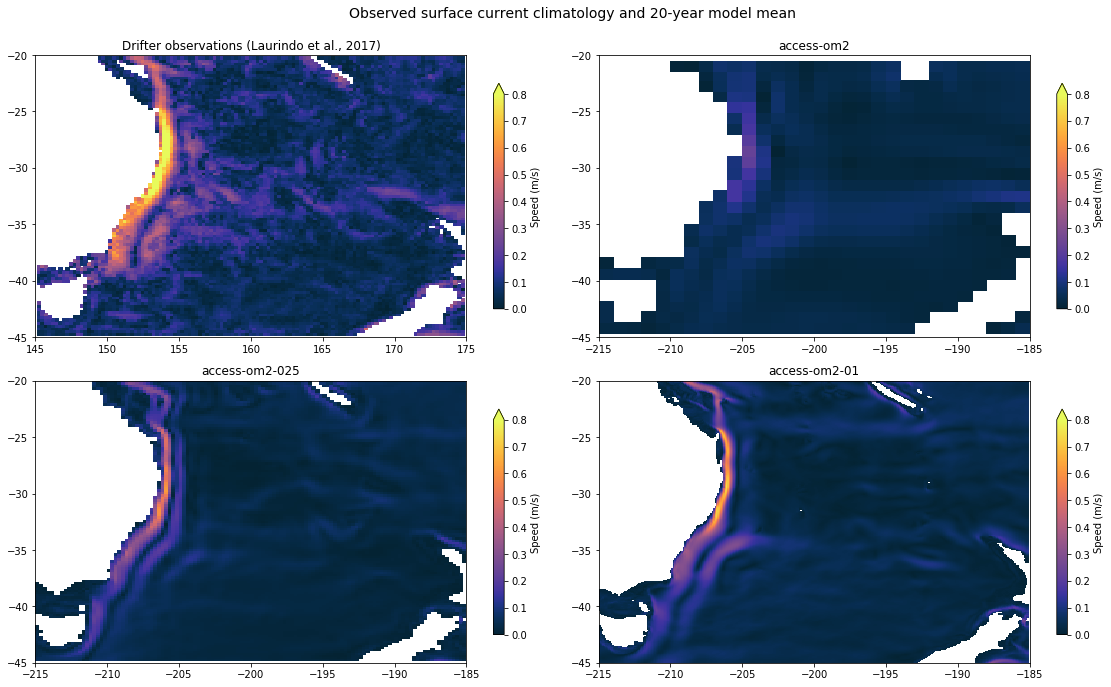

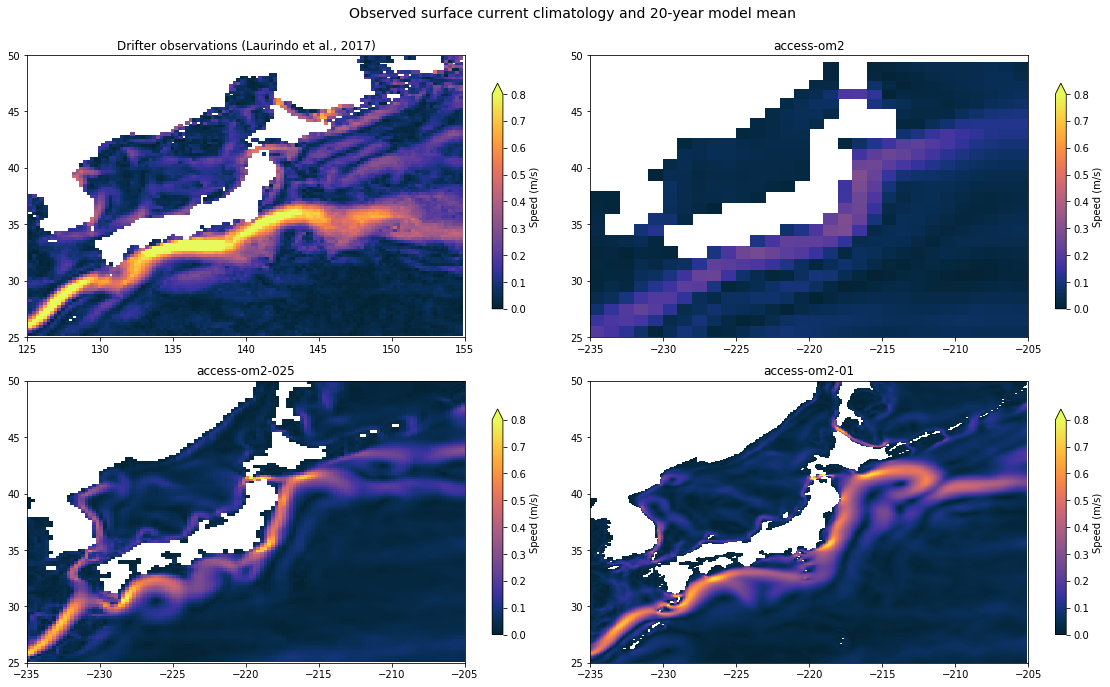

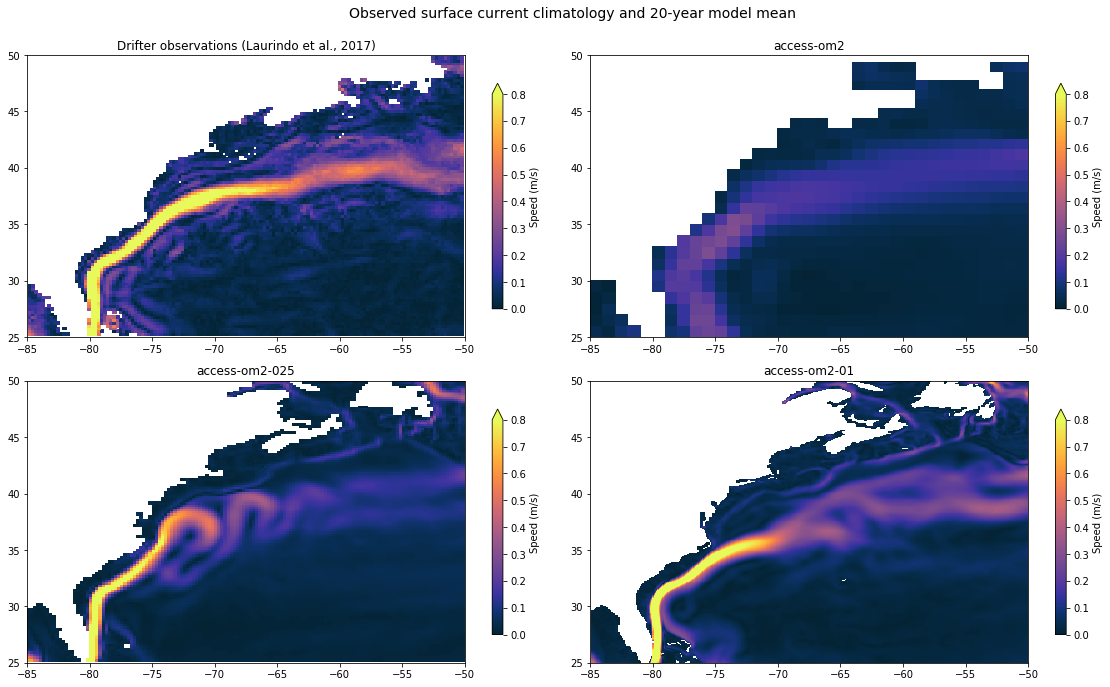

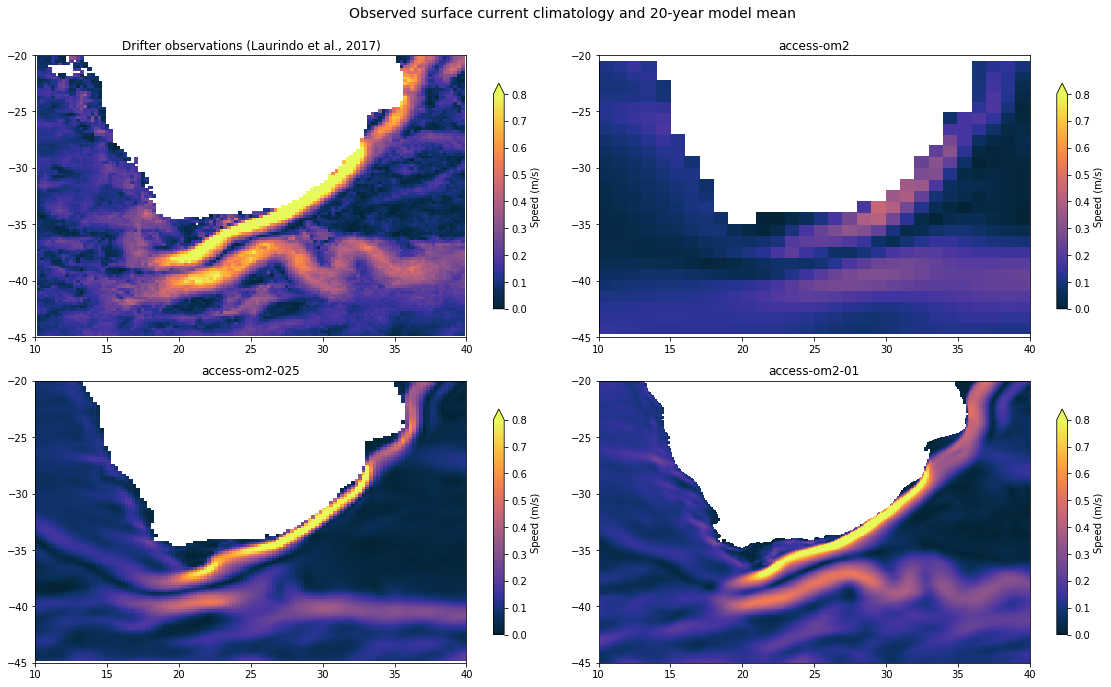

In [9]:
# plot obs and all model mean speeds in each location
vmax = 0.8
nrows = 2
ncols = math.ceil((len(speeds)+1)/nrows)
for locname,loc in locations.items():
    fig = plt.figure(figsize=(16,10))
    fig.suptitle('Observed surface current climatology and '+str(clim_years)+'-year model mean', fontsize=14)
    oloc = copy.copy(loc)
    # BUG: this probably won't work for regions that straddle 180E
    if oloc[0]<-180:
        oloc[0] = oloc[0]+360
    if oloc[1]<-180:
        oloc[1] = oloc[1]+360
    obs_speed_loc = obs_speed.sel(latitude=slice(oloc[2],oloc[3])).sel(longitude=slice(oloc[0],oloc[1]))
    ax = fig.add_subplot(nrows, ncols, 1)
    cax = ax.pcolormesh(obs_speed_loc.longitude, obs_speed_loc.latitude, np.swapaxes(obs_speed_loc,0,1), 
                        shading='flat', cmap=cm.cm.thermal, vmin=0, vmax=vmax)
    plt.title('Drifter observations (Laurindo et al., 2017)', fontsize=12)
    plt.xlim(oloc[0],oloc[1])
    plt.ylim(oloc[2],oloc[3])
    fig.colorbar(cax,shrink=0.8,label='Speed (m/s)',extend='max')

    for i, ekey in enumerate(speeds.keys()):
        ax = fig.add_subplot(nrows, ncols, i+2)
        speed = speeds[ekey]['speed'].sel(yu_ocean=slice(loc[2],loc[3])).sel(xu_ocean=slice(loc[0],loc[1]))
        cax = ax.pcolormesh(speed.xu_ocean, speed.yu_ocean, speed, 
                            shading='flat', cmap=cm.cm.thermal, vmin=0, vmax=vmax)
        plt.title(speeds[ekey]['model'], fontsize=12)
        plt.xlim(loc[0],loc[1])
        plt.ylim(loc[2],loc[3])
        fig.colorbar(cax,shrink=0.8,label='Speed (m/s)',extend='max')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    savefigure(locname+'_clim')

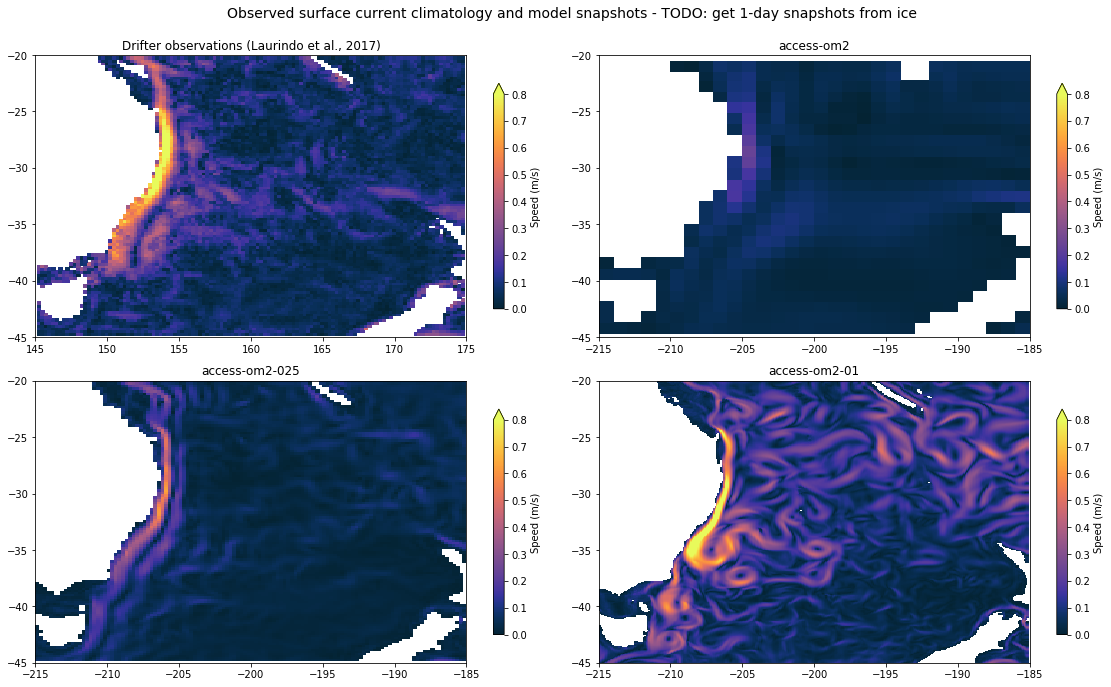

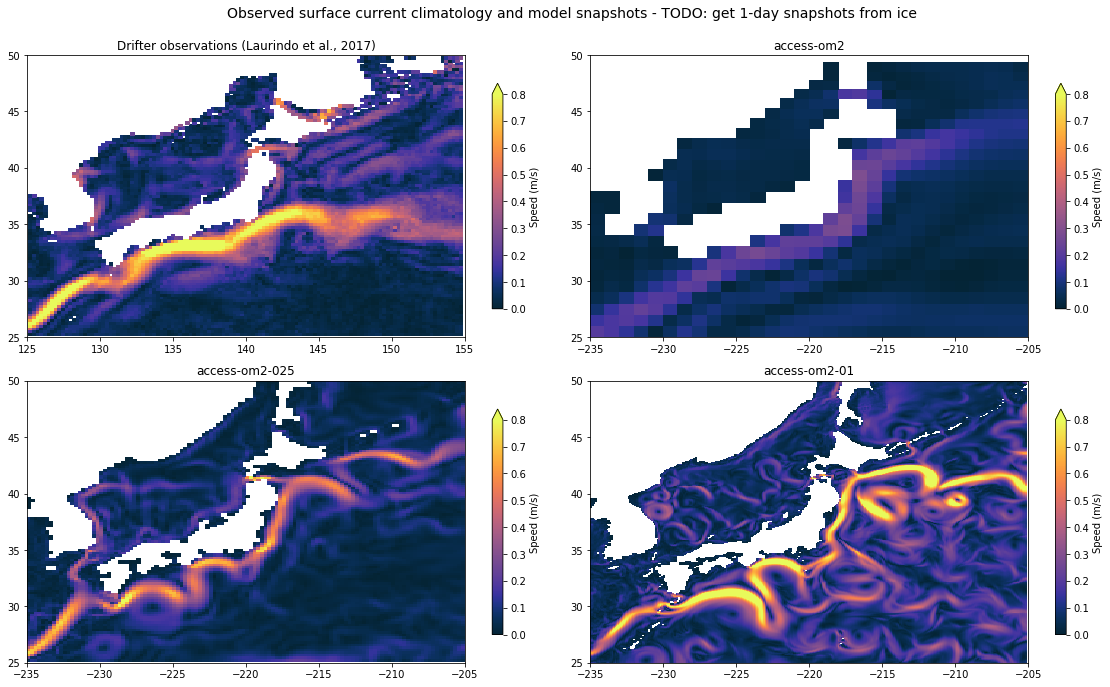

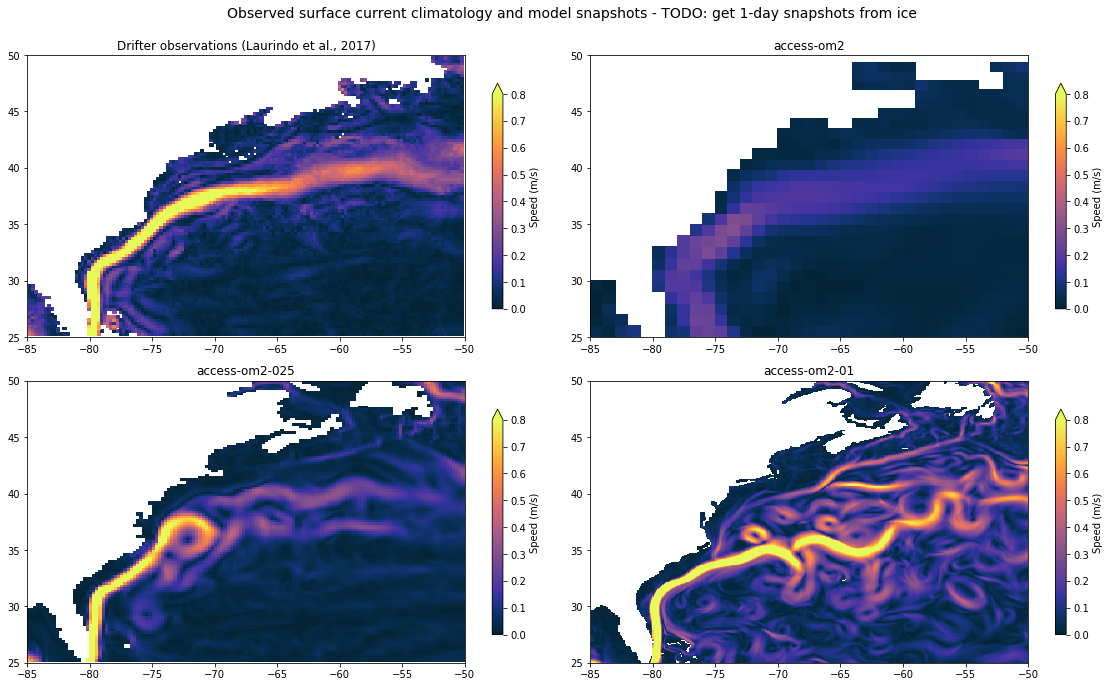

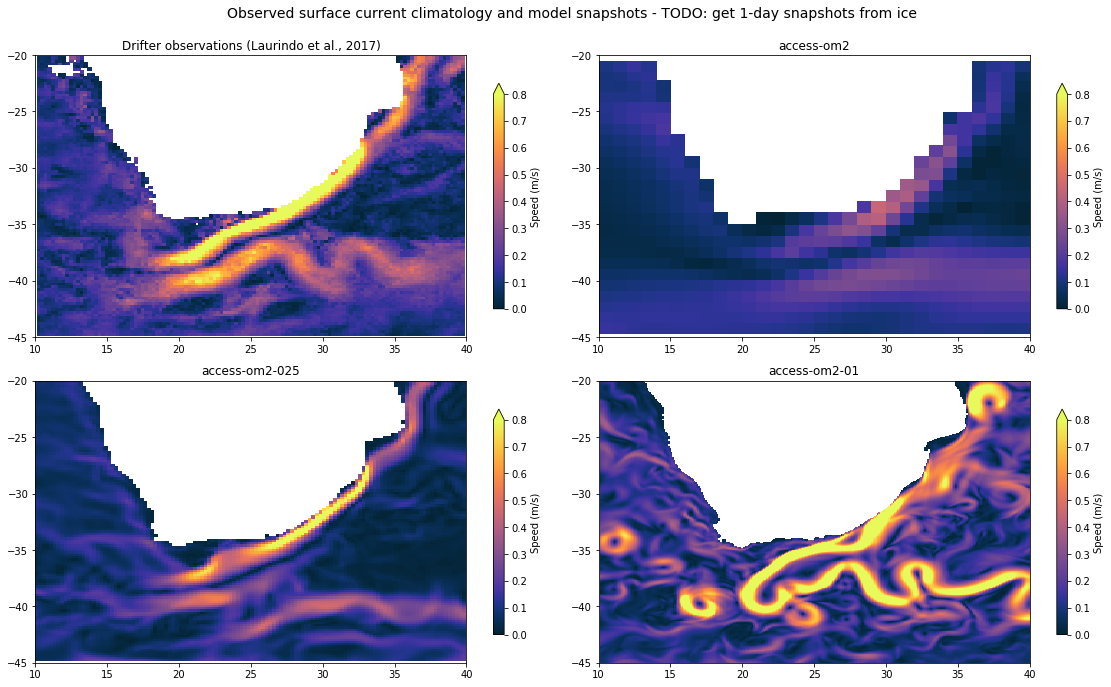

In [10]:
# plot obs and all model snapshot speeds in each location

# TODO: get 1-day snapshots from ice?

vmax = 0.8
nrows = 2
ncols = math.ceil((len(speeds)+1)/nrows)
for locname,loc in locations.items():
    fig = plt.figure(figsize=(16,10))
    fig.suptitle('Observed surface current climatology and model snapshots - TODO: get 1-day snapshots from ice', fontsize=14)
    oloc = copy.copy(loc)
    # BUG: this probably won't work for regions that straddle 180E
    if oloc[0]<-180:
        oloc[0] = oloc[0]+360
    if oloc[1]<-180:
        oloc[1] = oloc[1]+360
    obs_speed_loc = obs_speed.sel(latitude=slice(oloc[2],oloc[3])).sel(longitude=slice(oloc[0],oloc[1]))
    ax = fig.add_subplot(nrows, ncols, 1)
    cax = ax.pcolormesh(obs_speed_loc.longitude, obs_speed_loc.latitude, np.swapaxes(obs_speed_loc,0,1), 
                        shading='flat', cmap=cm.cm.thermal, vmin=0, vmax=vmax)
    plt.title('Drifter observations (Laurindo et al., 2017)', fontsize=12)
    plt.xlim(oloc[0],oloc[1])
    plt.ylim(oloc[2],oloc[3])
    fig.colorbar(cax,shrink=0.8,label='Speed (m/s)',extend='max')

    for i, ekey in enumerate(speeds.keys()):
        ax = fig.add_subplot(nrows, ncols, i+2)
        speed = speeds[ekey]['speed_snap'].sel(yu_ocean=slice(loc[2],loc[3])).sel(xu_ocean=slice(loc[0],loc[1]))
        cax = ax.pcolormesh(speed.xu_ocean, speed.yu_ocean, speed, 
                            shading='flat', cmap=cm.cm.thermal, vmin=0, vmax=vmax)
        plt.title(speeds[ekey]['model'], fontsize=12)
        plt.xlim(loc[0],loc[1])
        plt.ylim(loc[2],loc[3])
        fig.colorbar(cax,shrink=0.8,label='Speed (m/s)',extend='max')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    savefigure(locname+'_snap')